#Importing Libraries

In [ ]:
!pip install tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from tqdm import tqdm
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


#Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Image Checking

/content/drive/MyDrive/OWN/Compiled Models/Animals/animals/cats


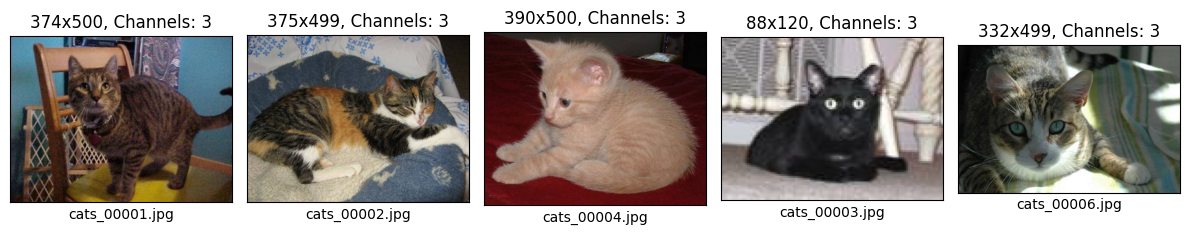

In [ ]:
img_dir = "/content/drive/MyDrive/OWN/Compiled Models/Animals/animals/cats"
training_dir= "/content/drive/MyDrive/OWN/Compiled Models/Animals/animals"

os.chdir(img_dir)
print(os.getcwd())
#print(os.listdir())

image_files = os.listdir()[:5]

plt.figure(figsize=(12, 8))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(img_dir, image_file)
    image_load = cv2.imread(image_path)
    height, width, channels = image_load.shape
    dimensions = f"{height}x{width}, Channels: {channels}"
    image_rgb = cv2.cvtColor(image_load, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(image_rgb)
    plt.title(dimensions)
    plt.xlabel(image_file)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

#Directory Names

In [ ]:
glob.glob(training_dir)
in_dir_list=[]
for subdir, _, files in os.walk(training_dir):
  in_dir_list.append(subdir)
for paths in in_dir_list:
  print (paths)

/content/drive/MyDrive/OWN/Compiled Models/Animals/animals
/content/drive/MyDrive/OWN/Compiled Models/Animals/animals/cats
/content/drive/MyDrive/OWN/Compiled Models/Animals/animals/dogs
/content/drive/MyDrive/OWN/Compiled Models/Animals/animals/panda


In [ ]:
label_map = {
    'cats': 1,
    'dogs': 2,
    'panda': 3,
}
Training_array = []
globs = glob.glob('*/*.jpg', root_dir=training_dir, recursive=True)
print(len(globs))


3000


#Counting Images

In [ ]:
i = 0
images_count= {}
for file_path in globs:
    filename = os.path.basename(file_path) #Returns only the filename
    folder_name = os.path.basename(os.path.dirname(file_path)) #Returns only the foldername
    images_count[folder_name] = images_count.get(folder_name, 0) + 1
print(images_count)

{'cats': 1000, 'dogs': 1000, 'panda': 1000}


In [ ]:
chdir = os.chdir(training_dir)
Loaded_Images = []
Loaded_Images_labels = []
for file_path in tqdm(globs, desc="Processing Images", unit="file"):
    filename = os.path.basename(file_path)  # Get the filename
    folder_name = os.path.basename(os.path.dirname(file_path))  # Get the folder name

    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img = cv2.imread(file_path)

        if img is not None:  # Check if the image is loaded successfully
            img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.array(img)

            if img.shape == (32, 32):  # Ensure the image has the correct shape
              Loaded_Images.append(img)
              Loaded_Images_labels.append (label_map[folder_name])

# Print the number of images processed
print(f"Total images processed: {len(Training_array)}")


Processing Images: 100%|██████████| 3000/3000 [25:59<00:00,  1.92file/s]

Total images processed: 0


#Verifying Loaded Image

3000
3000
[[126 129 133 ... 114 112 108]
 [126 129 133 ... 116 112 108]
 [130 131 134 ... 118 115 111]
 ...
 [ 24  21  59 ...  64  47  35]
 [ 24  25  61 ...  52  39  37]
 [ 22  24  43 ...  46  38  40]]
1


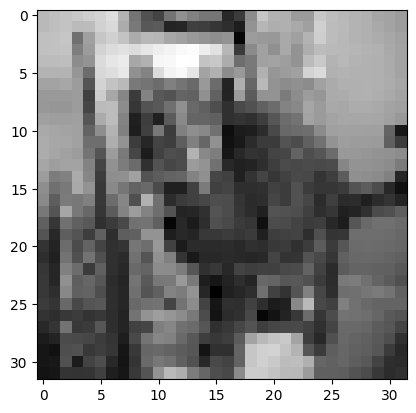

In [ ]:
print(len(Loaded_Images))
print(len(Loaded_Images_labels))
Loaded_Images = np.array(Loaded_Images)
Loaded_Images_labels = np.array(Loaded_Images_labels)
print(Loaded_Images[0])
plt.imshow(Loaded_Images[0], cmap='gray')
print(Loaded_Images_labels[0])

#Normalization

In [ ]:
Loaded_Images = Loaded_Images / 255.0
print(f"Training data shape: {Loaded_Images.shape}")
print(Loaded_Images[0])


Training data shape: (3000, 32, 32)
[[0.49411765 0.50588235 0.52156863 ... 0.44705882 0.43921569 0.42352941]
 [0.49411765 0.50588235 0.52156863 ... 0.45490196 0.43921569 0.42352941]
 [0.50980392 0.51372549 0.5254902  ... 0.4627451  0.45098039 0.43529412]
 ...
 [0.09411765 0.08235294 0.23137255 ... 0.25098039 0.18431373 0.1372549 ]
 [0.09411765 0.09803922 0.23921569 ... 0.20392157 0.15294118 0.14509804]
 [0.08627451 0.09411765 0.16862745 ... 0.18039216 0.14901961 0.15686275]]


In [ ]:
print(Loaded_Images_labels.shape)
Loaded_Images_labels = Loaded_Images_labels.reshape(-1)
print(Loaded_Images_labels[:25])

(3000,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


#Flattening

In [ ]:
Loaded_Images =  Loaded_Images.reshape(Loaded_Images.shape[0], -1)
Loaded_Images_labels = Loaded_Images_labels.flatten()

In [ ]:
print(Loaded_Images.shape)
print(Loaded_Images_labels.shape)

(3000, 1024)
(3000,)


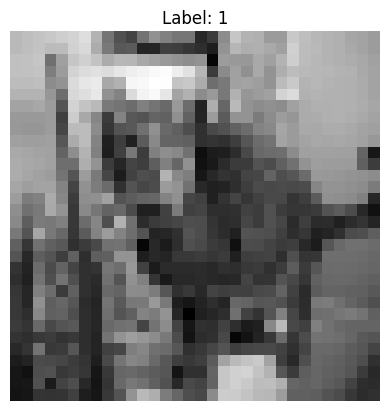

In [ ]:
image = Loaded_Images[0].reshape(32, 32)  # Reshape for The first image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {Loaded_Images_labels[0]}')
plt.axis('off')
plt.show()

In [ ]:
accuracies = []
confusion_matrices = []

#Function for Manhattan and Euclidean

In [ ]:
def compute_and_plot_accuracy(distance_metric):
    accuracy_man = {}

    for i in range(1, 6):  # Loop through 5 random states
        kfold = KFold(n_splits=5, random_state=i, shuffle=True)
        accuracies = []  # Reset accuracies for each random state

        for fold, (training_index, validation_index) in enumerate(kfold.split(Loaded_Images)):
            knn = KNeighborsClassifier(n_neighbors=5, metric=distance_metric)
            train_imgs, validation_imgs = Loaded_Images[training_index], Loaded_Images[validation_index]
            train_labels, validation_labels = Loaded_Images_labels[training_index], Loaded_Images_labels[validation_index]

            knn.fit(train_imgs, train_labels)
            validation_pred = knn.predict(validation_imgs)
            accuracy_current_fold = accuracy_score(validation_labels, validation_pred)
            accuracies.append(accuracy_current_fold)

            print(f"Random State {i}, Fold {fold + 1}, Accuracy ({distance_metric}): {accuracy_current_fold}")

        # Store the accuracies for each random state
        accuracy_man[i] = accuracies

    # Now compute fold-wise averages across all random states
    fold_wise_avg = np.mean([list(accuracy_man[i]) for i in accuracy_man], axis=0)

    # Now for plotting
    rndn_states = list(accuracy_man.keys())  # List of random states

    plt.figure(figsize=(7, 3))

    # Plotting accuracies for each random state
    for i in rndn_states:
        accuracies = accuracy_man[i]
        plt.scatter([i] * len(accuracies), accuracies, color='blue', alpha=0.6)

        # Annotate each point with its accuracy value
        for j, acc in enumerate(accuracies):
            plt.text(i, acc, f'{acc:.2f}', fontsize=10, ha='right', va='bottom')

    # Plot the fold-wise average accuracy line (5 points for 5 folds)
    plt.plot(range(1, 6), fold_wise_avg, color='red', marker='o', linestyle='--', label=f'Fold-wise Avg ({distance_metric})')

    # Add labels, grid, and title
    plt.grid(True)
    plt.xlabel("Random States")
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for Each Random State and Fold ({distance_metric})')
    plt.ylim(0.38, 0.58)
    plt.legend()

    # Show the plot
    plt.show()

Random State 1, Fold 1, Accuracy (manhattan): 0.48
Random State 1, Fold 2, Accuracy (manhattan): 0.5366666666666666
Random State 1, Fold 3, Accuracy (manhattan): 0.46
Random State 1, Fold 4, Accuracy (manhattan): 0.46166666666666667
Random State 1, Fold 5, Accuracy (manhattan): 0.4866666666666667
Random State 2, Fold 1, Accuracy (manhattan): 0.4583333333333333
Random State 2, Fold 2, Accuracy (manhattan): 0.49166666666666664
Random State 2, Fold 3, Accuracy (manhattan): 0.4866666666666667
Random State 2, Fold 4, Accuracy (manhattan): 0.4816666666666667
Random State 2, Fold 5, Accuracy (manhattan): 0.4683333333333333
Random State 3, Fold 1, Accuracy (manhattan): 0.4683333333333333
Random State 3, Fold 2, Accuracy (manhattan): 0.5183333333333333
Random State 3, Fold 3, Accuracy (manhattan): 0.45666666666666667
Random State 3, Fold 4, Accuracy (manhattan): 0.49833333333333335
Random State 3, Fold 5, Accuracy (manhattan): 0.505
Random State 4, Fold 1, Accuracy (manhattan): 0.475
Random Sta

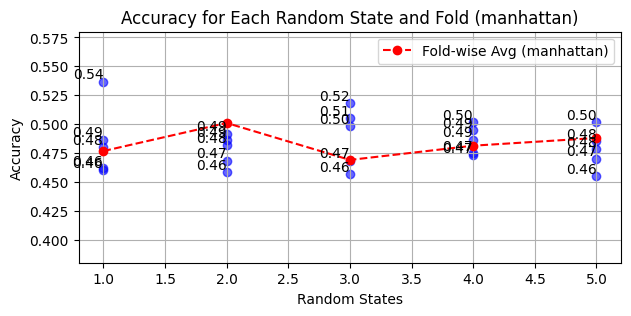

In [ ]:
compute_and_plot_accuracy('manhattan')

Random State 1, Fold 1, Accuracy (euclidean): 0.4266666666666667
Random State 1, Fold 2, Accuracy (euclidean): 0.45166666666666666
Random State 1, Fold 3, Accuracy (euclidean): 0.4116666666666667
Random State 1, Fold 4, Accuracy (euclidean): 0.43333333333333335
Random State 1, Fold 5, Accuracy (euclidean): 0.43166666666666664
Random State 2, Fold 1, Accuracy (euclidean): 0.41333333333333333
Random State 2, Fold 2, Accuracy (euclidean): 0.44666666666666666
Random State 2, Fold 3, Accuracy (euclidean): 0.42833333333333334
Random State 2, Fold 4, Accuracy (euclidean): 0.42833333333333334
Random State 2, Fold 5, Accuracy (euclidean): 0.42833333333333334
Random State 3, Fold 1, Accuracy (euclidean): 0.4266666666666667
Random State 3, Fold 2, Accuracy (euclidean): 0.45166666666666666
Random State 3, Fold 3, Accuracy (euclidean): 0.41833333333333333
Random State 3, Fold 4, Accuracy (euclidean): 0.425
Random State 3, Fold 5, Accuracy (euclidean): 0.4483333333333333
Random State 4, Fold 1, Accu

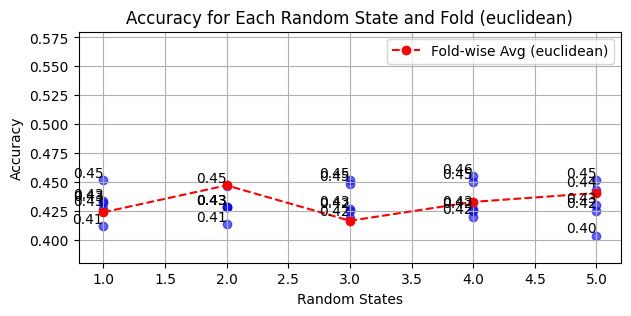

In [ ]:
compute_and_plot_accuracy('euclidean')

#5 Predictions

In [ ]:
random_integers = [random.randint(1, 3000) for _ in range(5)]
kfold = KFold(n_splits=5, random_state=3, shuffle=True)
for fold, (training_index, validation_index) in enumerate(kfold.split(Loaded_Images)):
        knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
        train_imgs, validation_imgs = Loaded_Images[training_index], Loaded_Images[validation_index]
        train_labels, validation_labels = Loaded_Images_labels[training_index], Loaded_Images_labels[validation_index]

        knn.fit(train_imgs, train_labels)
        validation_pred = knn.predict(validation_imgs)
        accuracy_current_fold = accuracy_score(validation_labels, validation_pred)
        accuracies.append(accuracy_current_fold)
        accr[fold + 1] = accuracy_current_fold

        # Display 5 predictions
        print(f"\nFold {fold + 1} Predictions euclidean:")
        for idx in range(5):
            print(f"Sample {idx + 1}: Predicted Label = {validation_pred[idx]}, True Label = {validation_labels[idx]}")

        print(f"Fold {fold + 1}, Accuracy euclidean): {accuracy_current_fold}")
print("\nOverall Accuracies:", accr)



Fold 1 Predictions euclidean:
Sample 1: Predicted Label = 1, True Label = 1
Sample 2: Predicted Label = 2, True Label = 1
Sample 3: Predicted Label = 1, True Label = 1
Sample 4: Predicted Label = 2, True Label = 1
Sample 5: Predicted Label = 1, True Label = 1
Fold 1, Accuracy euclidean): 0.4266666666666667

Fold 2 Predictions euclidean:
Sample 1: Predicted Label = 2, True Label = 1
Sample 2: Predicted Label = 1, True Label = 1
Sample 3: Predicted Label = 2, True Label = 1
Sample 4: Predicted Label = 2, True Label = 1
Sample 5: Predicted Label = 1, True Label = 1
Fold 2, Accuracy euclidean): 0.45166666666666666

Fold 3 Predictions euclidean:
Sample 1: Predicted Label = 2, True Label = 1
Sample 2: Predicted Label = 1, True Label = 1
Sample 3: Predicted Label = 1, True Label = 1
Sample 4: Predicted Label = 2, True Label = 1
Sample 5: Predicted Label = 1, True Label = 1
Fold 3, Accuracy euclidean): 0.41833333333333333

Fold 4 Predictions euclidean:
Sample 1: Predicted Label = 1, True Labe